In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as widgets
import tensorflow as tf
import numpy as np
import gzip
import pickle
import shutil
import os

with gzip.open("data.pklz", "rb") as f:
    images = pickle.load(f)

train_images.shape (9000, 84, 84)
val_images.shape (1000, 84, 84)


<IPython.core.display.Javascript object>


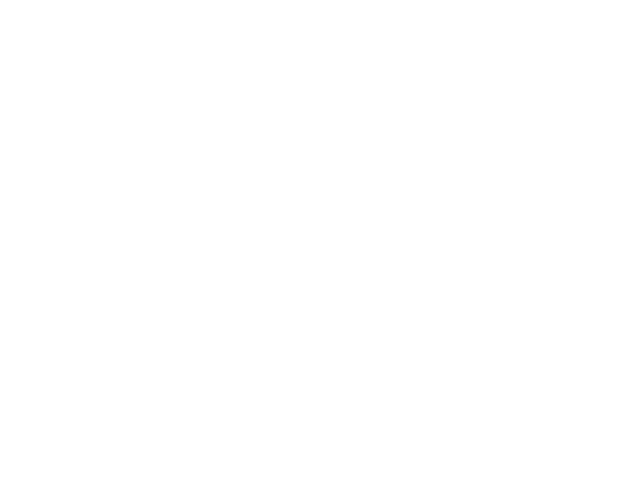

In [2]:
np.random.seed(0)
np.random.shuffle(images)

train_images = images[1000:]
val_images = images[:1000]

w, h = images.shape[1:3]
print("train_images.shape", train_images.shape)
print("val_images.shape", val_images.shape)
plt.imshow(train_images[-1], vmin=0, vmax=1, cmap="gray")
plt.show()

In [8]:
import sys
sys.path.append("..")
from vae import VAE

tf.reset_default_graph()

num_epochs = 10000
batch_size = 64
learning_rate = 3e-4
z_dim = 10
beta = 1
model_type = "mlp"
model_name = "bce_{}_zdim{}_beta{}".format(model_type, z_dim, beta)

vae = VAE(input_shape=(w, h),
          z_dim=z_dim, beta=beta,
          learning_rate=learning_rate,
          model_type=model_type, model_name=model_name)
vae.init_session()

min_val_loss = float("inf")
counter = 0
print("Training")
for epoch in range(num_epochs):
    if (epoch+1) % 10 == 0: print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train one epoch
    vae.train_one_epoch(train_images, batch_size)
    
    # Calculate evaluation metrics
    val_loss, _ = vae.evaluate(val_images, batch_size)
    
    # Early stopping
    if val_loss < min_val_loss:
        counter = 0
        min_val_loss = val_loss
    else:
        counter += 1
        if counter >= 10:
            print("No improvement in last 10 epochs, stopping")
            break
train_writer.flush()
val_writer.flush()

In [3]:
tf.reset_default_graph()

num_epochs = 10000
batch_size = 64
learning_rate = 3e-4
z_dim = 10
beta = 1

input_images = tf.placeholder(tf.float32, (None, w, h))
input_images_flatten = tf.layers.flatten(input_images)

# Dense VAE model
activation = tf.nn.leaky_relu

# Encoder
def encoder(images):
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE):
        x = tf.layers.dense(images, 512, activation=activation, name="dense1")
        x = tf.layers.dense(x, 256, activation=activation, name="dense2")
        vae_mean      = tf.layers.dense(x, z_dim, activation=None, name="vae_mean")
        vae_logstd_sq = tf.layers.dense(x, z_dim, activation=None, name="vae_logstd_sqare")
        return x, vae_mean, vae_logstd_sq

# Decoder
def decoder(z):
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
        x = tf.layers.dense(z, 256, activation=activation, name="dense1")
        x = tf.layers.dense(x, 512, activation=activation, name="dense2")
        x = tf.layers.dense(x, w * h, activation=None, name="dense3")
        return x


_, vae_mean, vae_logstd_sq = encoder(input_images_flatten)

vae_logstd_sq = tf.minimum(tf.check_numerics(vae_logstd_sq, "Invalid value for vae_logstd_sq"), 1e-3)

vae_normal = tf.distributions.Normal(vae_mean, tf.exp(0.5 * vae_logstd_sq), validate_args=True)
vae_sample = tf.squeeze(vae_normal.sample(1), axis=0)

reconstructed_images = decoder(vae_sample)
reconstructed_images_mean = tf.nn.sigmoid(decoder(vae_mean))

generative_z = tf.placeholder(tf.float32, (None, z_dim))
generated_images = decoder(generative_z)

def bce(t, y):
    epsilon = 1e-10
    return -tf.reduce_sum(t * tf.log(epsilon + y) + (1 - t) * tf.log(epsilon + 1 - y), axis=1)

def kl_divergence(mean, logstd_sq):
    return -0.5 * tf.reduce_sum(1 + logstd_sq - tf.square(mean) - tf.exp(logstd_sq), axis=1)

# Binary cross-entropy reconstruction loss
reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=input_images_flatten,
                logits=reconstructed_images),
            axis=1
        )
    )
#reconstruction_loss = tf.reduce_mean(bce(input_images, reconstructed_images))
kl_loss = tf.reduce_mean(kl_divergence(vae_mean, vae_logstd_sq))

# Total loss
loss = reconstruction_loss + beta * kl_loss

# Summary
mean_kl_loss, mean_kl_loss_update = tf.metrics.mean(kl_loss)
mean_reconstruction_loss, mean_reconstruction_loss_update = tf.metrics.mean(reconstruction_loss)
tf.summary.scalar("kl_loss", mean_kl_loss)
tf.summary.scalar("reconstruction_loss", mean_reconstruction_loss)
merge_op = tf.summary.merge_all()

# Minimize loss
#optimizer     = tf.train.AdamOptimizer(learning_rate=3e-4, epsilon=1e-5)
optimizer     = tf.train.AdamOptimizer(learning_rate=learning_rate)#, beta1=0.5)
train_step    = optimizer.minimize(loss)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

log_dir = "./vae_logs/bce_beta2"
if os.path.isdir(log_dir): shutil.rmtree(log_dir)
train_writer = tf.summary.FileWriter(os.path.join(log_dir, "train"), sess.graph)
val_writer = tf.summary.FileWriter(os.path.join(log_dir, "val"), sess.graph)

step_idx = 0
min_val_loss = float("inf")
counter = 0
print("Training")
for epoch in range(num_epochs):
    if (epoch+1) % 10 == 0: print(f"Epoch {epoch+1}/{num_epochs}")
    
    np.random.shuffle(train_images)
    sess.run(tf.local_variables_initializer())
    for i in range(train_images.shape[0] // batch_size):
        batch = train_images[i*batch_size:(i+1)*batch_size]
        r = sess.run([train_step, mean_kl_loss_update, mean_reconstruction_loss_update], feed_dict={
            input_images: batch
        })
    train_writer.add_summary(sess.run(merge_op), epoch)
        
    sess.run(tf.local_variables_initializer())
    for i in range(val_images.shape[0] // batch_size):
        batch = val_images[i*batch_size:(i+1)*batch_size]
        r = sess.run([merge_op, mean_kl_loss_update, mean_reconstruction_loss_update], feed_dict={
            input_images: batch
        })
    val_writer.add_summary(sess.run(merge_op), epoch)
    val_loss = sess.run(mean_reconstruction_loss)
    if val_loss < min_val_loss:
        counter = 0
        min_val_loss = val_loss
    else:
        counter += 1
        if counter >= 10:
            print("No improvement in last 10 epochs, stopping")
            break
train_writer.flush()
val_writer.flush()

Training
Epoch 10/10000
Epoch 20/10000
Epoch 30/10000
Epoch 40/10000
Epoch 50/10000
Epoch 60/10000
Epoch 70/10000
No improvement in last 10 epochs, stopping


<IPython.core.display.Javascript object>


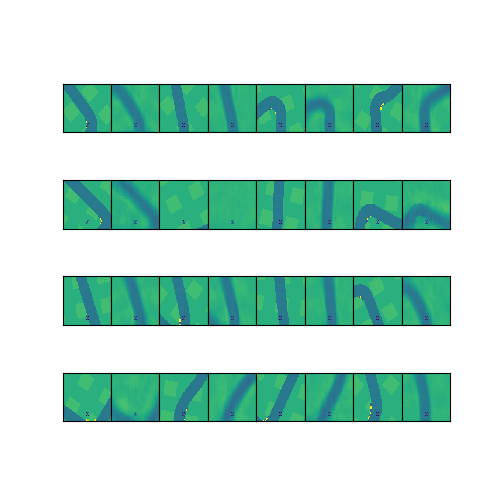

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as widgets

sample_idx = np.random.choice(val_images.shape[0], 16, replace=False)

orig_img = val_images[sample_idx]
recon_img = sess.run(reconstructed_images_mean, feed_dict={
    input_images: val_images[sample_idx]
})

fig, ax = plt.subplots(4, 4*2, figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

for i in range(4):
    for j in range(4):
        ax[i, j*2].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j*2].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j*2].imshow(orig_img[4 * i + j].reshape(w, h), vmin=0, vmax=1)
        ax[i, j*2+1].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j*2+1].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j*2+1].imshow(recon_img[4 * i + j].reshape(w, h), vmin=0, vmax=1)
plt.show()

<IPython.core.display.Javascript object>


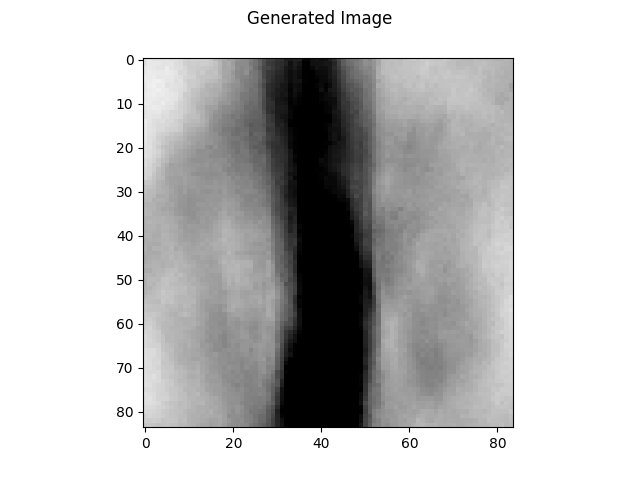

FloatSlider(value=0.0, description='z_dim[0]', max=3.0, min=-3.0, readout_format='.1f')

FloatSlider(value=0.0, description='z_dim[1]', max=3.0, min=-3.0, readout_format='.1f')

FloatSlider(value=0.0, description='z_dim[2]', max=3.0, min=-3.0, readout_format='.1f')

FloatSlider(value=0.0, description='z_dim[3]', max=3.0, min=-3.0, readout_format='.1f')

FloatSlider(value=0.0, description='z_dim[4]', max=3.0, min=-3.0, readout_format='.1f')

FloatSlider(value=0.0, description='z_dim[5]', max=3.0, min=-3.0, readout_format='.1f')

FloatSlider(value=0.0, description='z_dim[6]', max=3.0, min=-3.0, readout_format='.1f')

FloatSlider(value=0.0, description='z_dim[7]', max=3.0, min=-3.0, readout_format='.1f')

FloatSlider(value=0.0, description='z_dim[8]', max=3.0, min=-3.0, readout_format='.1f')

FloatSlider(value=0.0, description='z_dim[9]', max=3.0, min=-3.0, readout_format='.1f')

In [5]:
curr_z = np.zeros((1, z_dim))
img = sess.run(generated_images, feed_dict={
    generative_z: curr_z
})
fig = plt.figure()
fig.suptitle("Generated Image")
ax = fig.add_subplot(1, 1, 1)
plot = ax.imshow(img.reshape(w, h), vmin=0, vmax=1, cmap="gray")

for dim_idx in range(z_dim):
    slider = widgets.FloatSlider(
        value=0.0,
        min=-3,
        max= 3,
        step=0.1,
        description=f"z_dim[{dim_idx}]",
        disabled=False,
        continuous_update=True,
        orientation="horizontal",
        readout=True,
        readout_format=".1f",
    )

    def create_slider_event(dim_idx):
        def func(change):
            curr_z[0, dim_idx] = change["new"]
            img = sess.run(generated_images, feed_dict={
                generative_z: curr_z
            })
            plot.set_data(img.reshape(w, h))
            fig.canvas.draw()
        return func

    slider.observe(create_slider_event(dim_idx), names="value")
    display(slider)